# COVID-19 Data Analysis Project

Module 12 — COVID-19 & World Happiness analysis. This notebook loads the provided COVID-19 confirmed and deaths datasets and the Worldwide Happiness Report, performs cleaning, aggregates country-level metrics (total confirmed & deaths as of 2020-04-30), merges with happiness indicators, and performs EDA and visualizations to explore relationships.

Paths to the provided files are already set to the files you uploaded. Run the notebook cells in order.

## 1. Load datasets

Load the uploaded CSV files (confirmed cases, deaths, happiness).

In [1]:
import pandas as pd, numpy as np
covid_confirmed = pd.read_csv('covid19_Confirmed_dataset.csv')
covid_deaths = pd.read_csv('covid19_deaths_dataset.csv')
happiness = pd.read_csv('worldwide_happiness_report.csv')

print('Confirmed shape:', covid_confirmed.shape)
print('Deaths shape   :', covid_deaths.shape)
print('Happiness shape:', happiness.shape)

# show heads
display(covid_confirmed.head())
display(covid_deaths.head())
display(happiness.head())

Confirmed shape: (266, 104)
Deaths shape   : (266, 104)
Happiness shape: (156, 9)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,609,634,663,678,712,726,736,750,766,773
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,717,723,723,731,738,738,743,743,743,745
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,25,25,25,25,26,27,27,27,27


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,36,40,42,43,47,50,57,58,60,64
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,27,27,27,27,28,28,30,30,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,392,402,407,415,419,425,432,437,444,450
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,37,37,37,40,40,40,40,41,42,42
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


## 2. Preprocess COVID data

Aggregate province/state rows into country totals and extract totals up to 2020-04-30.

In [2]:
# Function to convert wide date columns into country-level totals and extract final date total
def preprocess_timeseries(df, value_name='confirmed'):
    # Identify date columns (all columns after the first 4 typically)
    non_date_cols = ['Province/State','Country/Region','Lat','Long']
    date_cols = [c for c in df.columns if c not in non_date_cols]
    # Melt to long format
    long = df.melt(id_vars=['Province/State','Country/Region','Lat','Long'], value_vars=date_cols, var_name='date', value_name=value_name)
    # Parse dates (US style month/day/year)
    long['date'] = pd.to_datetime(long['date'])
    # Aggregate by country and date
    agg = long.groupby(['Country/Region','date'])[value_name].sum().reset_index()
    # Pivot to have dates as columns if needed, but for now return aggregated long format
    return agg

confirmed_long = preprocess_timeseries(covid_confirmed, 'confirmed')
deaths_long = preprocess_timeseries(covid_deaths, 'deaths')

print('Confirmed long shape:', confirmed_long.shape)
print('Deaths long shape   :', deaths_long.shape)

# Extract totals up to 2020-04-30
cutoff = pd.to_datetime('2020-04-30')
confirmed_latest = confirmed_long[confirmed_long['date'] == cutoff].rename(columns={'confirmed':'total_confirmed'})
deaths_latest = deaths_long[deaths_long['date'] == cutoff].rename(columns={'deaths':'total_deaths'})

country_totals = confirmed_latest[['Country/Region','total_confirmed']].merge(deaths_latest[['Country/Region','total_deaths']], on='Country/Region', how='outer').fillna(0)
country_totals['total_confirmed'] = country_totals['total_confirmed'].astype(int)
country_totals['total_deaths'] = country_totals['total_deaths'].astype(int)

country_totals = country_totals.rename(columns={'Country/Region':'country'})
country_totals.head()

Confirmed long shape: (18700, 3)
Deaths long shape   : (18700, 3)


C:\Users\Piyush_Srivastava\AppData\Local\Temp\ipykernel_20516\3399939610.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  long['date'] = pd.to_datetime(long['date'])
C:\Users\Piyush_Srivastava\AppData\Local\Temp\ipykernel_20516\3399939610.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  long['date'] = pd.to_datetime(long['date'])


,country,total_confirmed,total_deaths
0,Afghanistan,2171,64
1,Albania,773,31
2,Algeria,4006,450
3,Andorra,745,42
4,Angola,27,2


### Top countries by confirmed cases and deaths (as of 2020-04-30)

In [3]:
top_cases = country_totals.sort_values('total_confirmed', ascending=False).head(10)
top_deaths = country_totals.sort_values('total_deaths', ascending=False).head(10)
print('Top 10 by confirmed cases:')
display(top_cases)
print('\nTop 10 by deaths:')
display(top_deaths)

Top 10 by confirmed cases:


,country,total_confirmed,total_deaths
173,US,1069424,62996
157,Spain,213435,24543
85,Italy,205463,27967
177,United Kingdom,172481,26842
62,France,167299,24410
66,Germany,163009,6623
172,Turkey,120204,3174
139,Russia,106498,1073
81,Iran,94640,6028
23,Brazil,87187,6006



Top 10 by deaths:


,country,total_confirmed,total_deaths
173,US,1069424,62996
85,Italy,205463,27967
177,United Kingdom,172481,26842
157,Spain,213435,24543
62,France,167299,24410
16,Belgium,48519,7594
66,Germany,163009,6623
81,Iran,94640,6028
23,Brazil,87187,6006
121,Netherlands,39512,4811


## 3. Prepare Happiness dataset

Rename columns for easier merging and inspect relevant indicators.

In [4]:
h = happiness.copy()
# Rename 'Country or region' to country to align with COVID country names
h = h.rename(columns={'Country or region':'country', 'Score':'happiness_score', 'GDP per capita':'gdp_per_capita', 'Social support':'social_support', 'Healthy life expectancy':'life_expectancy', 'Freedom to make life choices':'freedom', 'Generosity':'generosity', 'Perceptions of corruption':'corruption'})
# Keep relevant columns
h = h[['country','happiness_score','gdp_per_capita','social_support','life_expectancy','freedom','generosity','corruption']]
display(h.head())
h.shape

,country,happiness_score,gdp_per_capita,social_support,life_expectancy,freedom,generosity,corruption
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


(156, 8)

## 4. Merge COVID totals with Happiness indicators

Perform a left merge on country names and inspect mismatches.

In [5]:
merged = h.merge(country_totals, on='country', how='left')
# Countries with no COVID data will have NaN -> set to 0
merged['total_confirmed'] = merged['total_confirmed'].fillna(0).astype(int)
merged['total_deaths'] = merged['total_deaths'].fillna(0).astype(int)

# Show merged head and number of matched countries
display(merged.head())
print('Merged rows:', merged.shape[0])

,country,happiness_score,gdp_per_capita,social_support,life_expectancy,freedom,generosity,corruption,total_confirmed,total_deaths
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,4995,211
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,9356,452
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,7738,210
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,1797,10
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,39512,4811


Merged rows: 156


### Check for countries present in COVID data but missing in Happiness dataset (first 20)

In [6]:
covid_countries = set(country_totals['country'].unique())
happy_countries = set(h['country'].unique())
missing = sorted(list(covid_countries - happy_countries))
print('Number of COVID countries not in happiness dataset:', len(missing))
missing[:20]

Number of COVID countries not in happiness dataset: 44


['Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Bahamas',
 'Barbados',
 'Belize',
 'Brunei',
 'Burma',
 'Cabo Verde',
 "Cote d'Ivoire",
 'Cuba',
 'Czechia',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'Fiji',
 'Grenada']

## 5. Correlation Analysis

Compute correlations between COVID impact (cases & deaths) and happiness indicators.

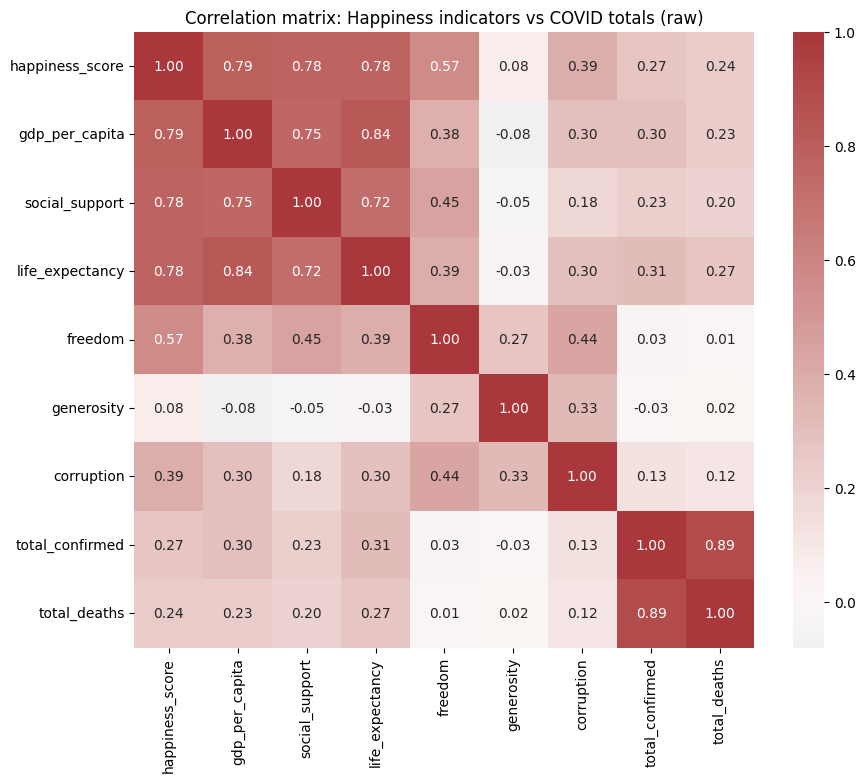

,total_deaths,total_confirmed
happiness_score,0.237827,0.273789
gdp_per_capita,0.233326,0.302978
social_support,0.195765,0.226511
life_expectancy,0.272033,0.314703
freedom,0.011358,0.031989


In [7]:
import seaborn as sns, matplotlib.pyplot as plt
# Create columns for per-capita if population not available; we'll analyze raw totals here
corr_df = merged[['happiness_score','gdp_per_capita','social_support','life_expectancy','freedom','generosity','corruption','total_confirmed','total_deaths']].copy()
corr = corr_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation matrix: Happiness indicators vs COVID totals (raw)')
plt.show()

corr[['total_deaths','total_confirmed']].loc[['happiness_score','gdp_per_capita','social_support','life_expectancy','freedom']]

## 6. Scatter Plots & Visualizations

Scatter plots to inspect relationships.

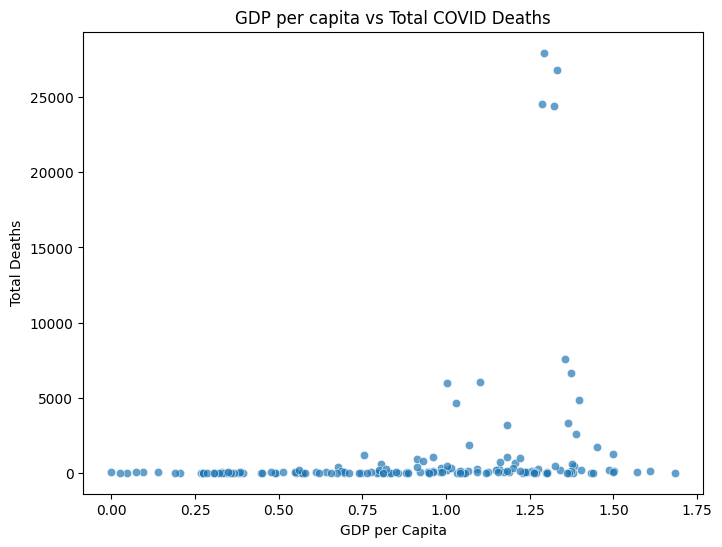

In [8]:
# Use seaborn/matplotlib already imported in earlier cells (they were imported in cell 14).
# Ensure 'merged' exists; if not, try to recreate it from 'h' and 'country_totals' which are created in earlier cells.
if 'merged' not in globals():
	if ('h' in globals()) and ('country_totals' in globals()):
		merged = h.merge(country_totals, on='country', how='left')
		merged['total_confirmed'] = merged['total_confirmed'].fillna(0).astype(int)
		merged['total_deaths'] = merged['total_deaths'].fillna(0).astype(int)
	else:
		raise NameError("Variable 'merged' is not defined. Please run the earlier cells that create 'h' (happiness) and 'country_totals' (COVID totals) before running this cell.")

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x="gdp_per_capita", y="total_deaths", alpha=0.7)
plt.title("GDP per capita vs Total COVID Deaths")
plt.xlabel("GDP per Capita")
plt.ylabel("Total Deaths")
plt.show()

## 7. Notes, Limitations & Next Steps

- The COVID datasets are raw cumulative counts; ideally we'd compute per-capita metrics using population data.
- Country name mismatches may reduce merge quality; consider manual mapping for known mismatches.
- Consider time-series analysis (cases over time) and region-level analysis for deeper insights.

Next steps: add population, compute cases/deaths per 100k, build regression models controlling for GDP, life expectancy, etc.